In [ ]:
# === colab configuration ===
# p.s. when training on colab, weights are saved on Drive (directory DSCAS/weights).
# p.p.s. skip this cell if running demo file locally!

! pip install torch-summary
! pip install ray
from google.colab import drive
import sys

# setting paths
repository_path = '/content/deep-seasonal-color-analysis-system/'
dataset_path = repository_path + 'headsegmentation_dataset_ccncsa/'
dataset_path_drive = '/content/drive/MyDrive/DSCAS/headsegmentation_dataset_ccncsa/'
weights_path = repository_path + 'models/weights/'
weights_path_drive = '/content/drive/MyDrive/DSCAS/weights/'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/mrcmich/deep-seasonal-color-analysis-system.git
! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'fastscnn_hyperparameters_tuning__refactoring'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

In [1]:
import torch
from torch import nn
from torchvision import ops
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.local.FastSCNN.models import fast_scnn
from metrics_and_losses import metrics
from utils import segmentation_labels, utils
import matplotlib.pyplot as plt
from palette_classification import color_processing
import torchsummary
from models import config
from functools import partial
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import pprint

try:
  executing_on_colab
except NameError:
  executing_on_colab = False
  weights_path = config.WEIGHTS_PATH
  dataset_path = config.DATASET_PATH

c:\Users\matte\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# defining transforms
tH, tW = 256, 256
image_transform = T.Compose([T.Resize((tH, tW)), T.Normalize(config.NORMALIZE_MEAN, config.NORMALIZE_STD)])
target_transform = T.Compose([T.Resize((tH, tW))])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path, file_name=config.DATASET_INDEX_NAME)
X_train, X_test, Y_train, Y_test = train_test_split(
    img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
train_dataset = dataset.CcncsaDataset(X_train, Y_train, image_transform, target_transform)
test_dataset = dataset.CcncsaDataset(X_test, Y_test, image_transform, target_transform)

# setting up model and fixed (initially) hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 1
batch_size = 32
score_fn = metrics.batch_mIoU
learning_rate = 0.01
class_weights = torch.tensor(config.CLASS_WEIGHTS)

In [ ]:
# === selecting best loss function ===

results = []

loss_fn_candidates = [
    nn.CrossEntropyLoss(),
    nn.CrossEntropyLoss(weight=class_weights.to(device))]

for loss_fn in loss_fn_candidates:
    model = fast_scnn.FastSCNN(n_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    partial_results = training_and_testing.train_model(
        device, model, train_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
        lr_scheduler=None, verbose=True, evaluate=True)
    results.append(partial_results)

Device: cuda.
--- Epoch 1/10 ---
average_train_loss: 0.4739366758752752, average_train_score: 0.39224526286125183
average_val_loss: 0.3483721320591276, average_val_score: 0.4400932192802429
--- Epoch 2/10 ---
average_train_loss: 0.2780017458390646, average_train_score: 0.48991259932518005
average_val_loss: 0.26761983760765623, average_val_score: 0.5264581441879272
--- Epoch 3/10 ---
average_train_loss: 0.21041263911628996, average_train_score: 0.5458094477653503
average_val_loss: 0.20706917345523834, average_val_score: 0.5547248721122742
--- Epoch 4/10 ---
average_train_loss: 0.18337743011889635, average_train_score: 0.5704610347747803
average_val_loss: 0.17658594499031702, average_val_score: 0.566706657409668
--- Epoch 5/10 ---
average_train_loss: 0.16300309848496716, average_train_score: 0.5896056294441223
average_val_loss: 0.17556485332666882, average_val_score: 0.5751510858535767
--- Epoch 6/10 ---
average_train_loss: 0.1543923871979075, average_train_score: 0.6003934741020203
aver

training score after 10 epochs: 0.6355282068252563
validation score after 10 epochs: 0.6409175395965576


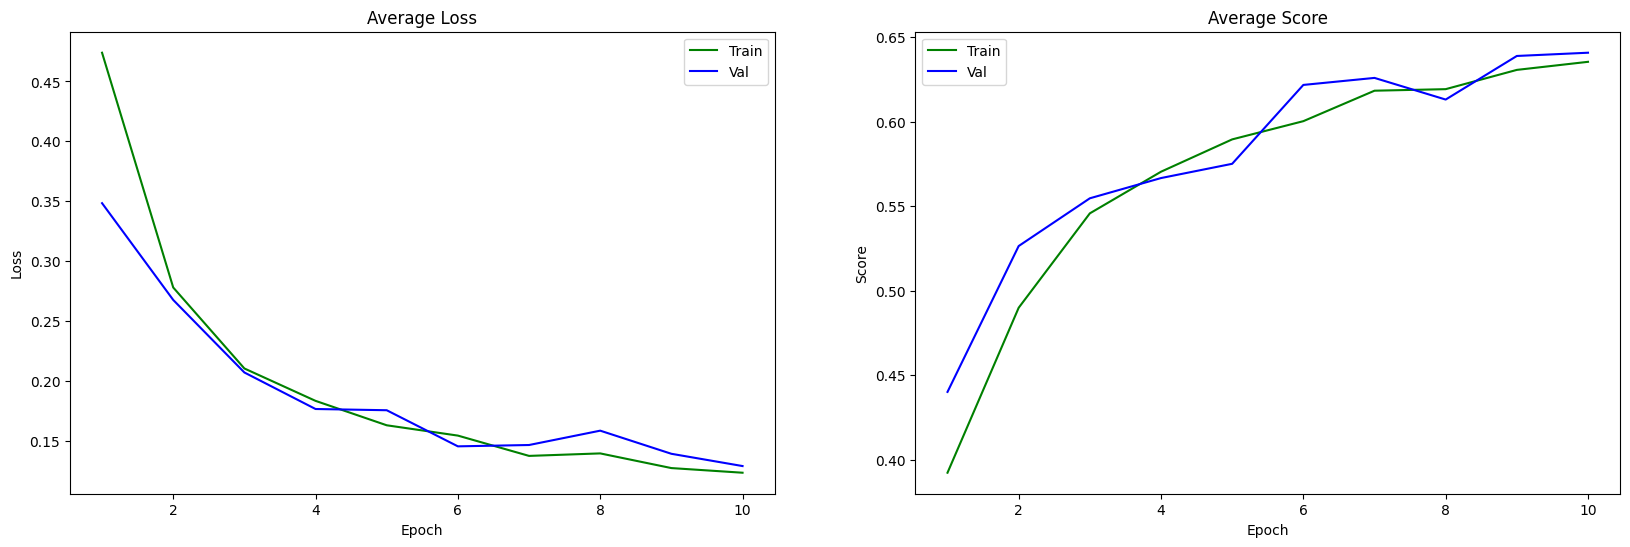

In [ ]:
# Cross Entropy Loss
last_train_score = results[0]['average_train_score'][-1]
last_val_score = results[0]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[0], plotsize=(20, 6))

training score after 10 epochs: 0.6543341875076294
validation score after 10 epochs: 0.6612251400947571


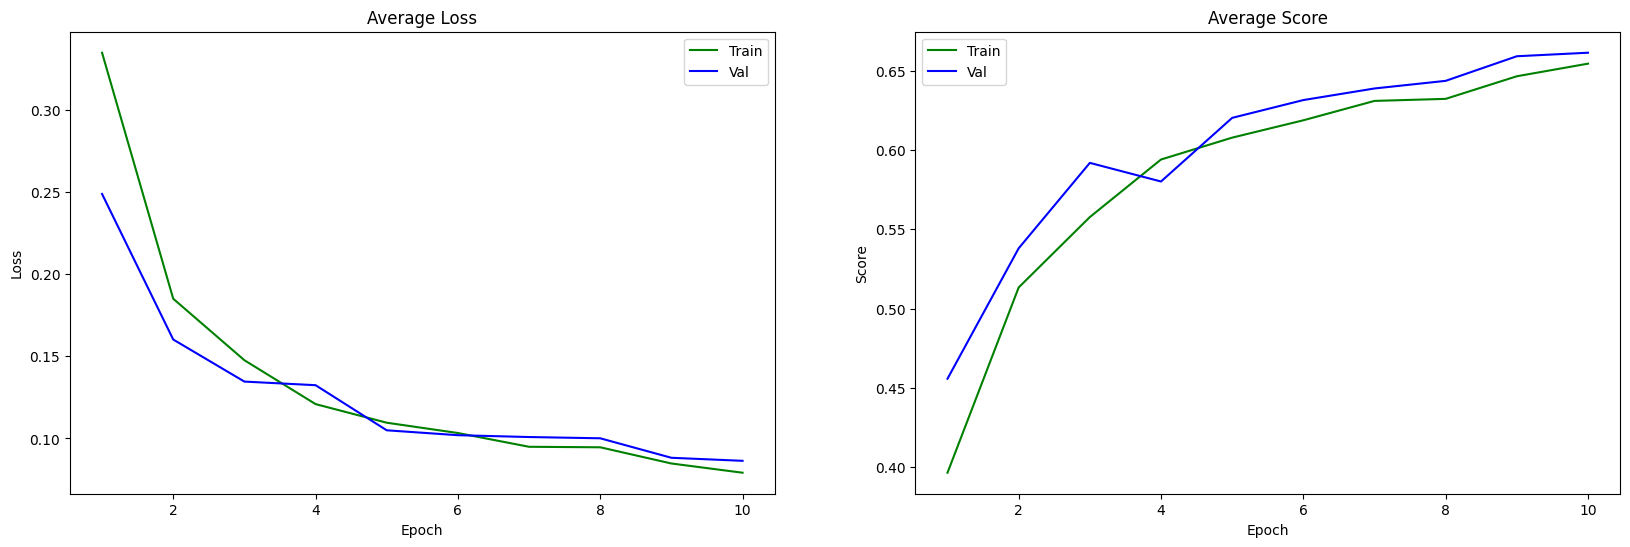

In [ ]:
# Weighted Cross Entropy Loss
last_train_score = results[1]['average_train_score'][-1]
last_val_score = results[1]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[1], plotsize=(20, 6))

In [ ]:
# === selecting best optimizer ===

results = []
loss_fn = nn.CrossEntropyLoss()

models = [
    fast_scnn.FastSCNN(n_classes),
    fast_scnn.FastSCNN(n_classes),
    fast_scnn.FastSCNN(n_classes),
]

optimizer_candidates = [
    torch.optim.SGD(models[0].parameters(), lr=learning_rate),
    torch.optim.Adam(models[1].parameters(), lr=learning_rate),
    torch.optim.AdamW(models[2].parameters(), lr=learning_rate)]

for i, optimizer in enumerate(optimizer_candidates):
    model = models[i]
    partial_results = training_and_testing.train_model(
        device, model, train_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
        lr_scheduler=None, verbose=True, evaluate=True)
    results.append(partial_results)

Device: cuda.
--- Epoch 1/10 ---
average_train_loss: 1.0381602514163721, average_train_score: 0.30737823247909546
average_val_loss: 0.810957742115808, average_val_score: 0.3400426208972931
--- Epoch 2/10 ---
average_train_loss: 0.7285676238543627, average_train_score: 0.35236549377441406
average_val_loss: 0.7278461087317694, average_val_score: 0.3525333106517792
--- Epoch 3/10 ---
average_train_loss: 0.6324225087620934, average_train_score: 0.37344884872436523
average_val_loss: 0.6006390026637486, average_val_score: 0.3766454756259918
--- Epoch 4/10 ---
average_train_loss: 0.5803550207546974, average_train_score: 0.3841699957847595
average_val_loss: 0.56080224589696, average_val_score: 0.3879760801792145
--- Epoch 5/10 ---
average_train_loss: 0.5413699721508896, average_train_score: 0.3912029266357422
average_val_loss: 0.5245489946433476, average_val_score: 0.39387911558151245
--- Epoch 6/10 ---
average_train_loss: 0.5082296311345875, average_train_score: 0.3971135914325714
average_val

training score after 10 epochs: 0.40985628962516785
validation score after 10 epochs: 0.4089634120464325


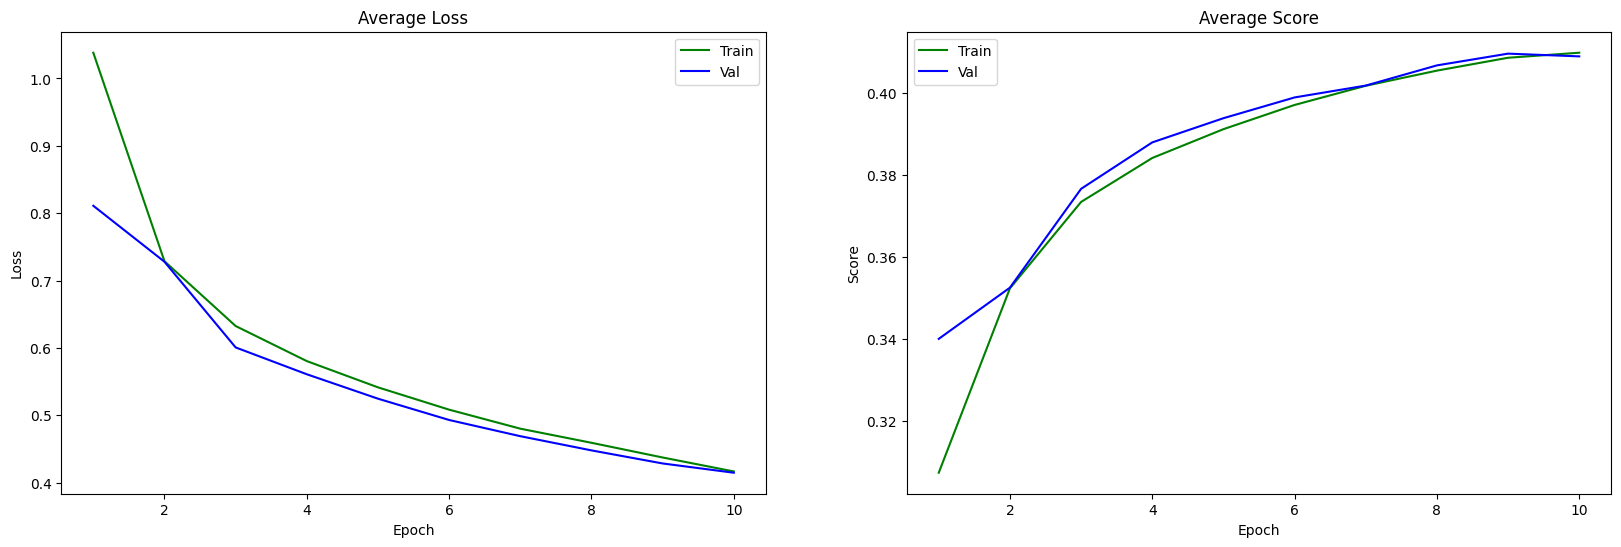

In [ ]:
# SGD
last_train_score = results[0]['average_train_score'][-1]
last_val_score = results[0]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[0], plotsize=(20, 6))

training score after 10 epochs: 0.6398380398750305
validation score after 10 epochs: 0.6192876100540161


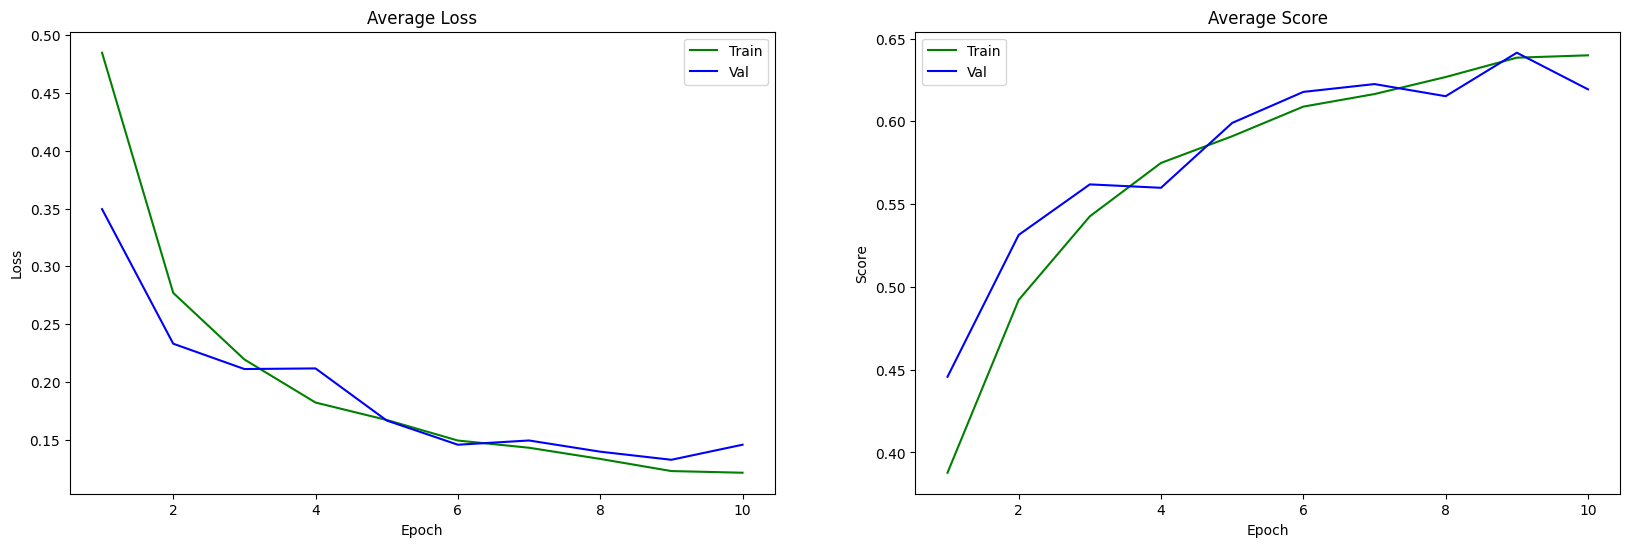

In [ ]:
# Adam
last_train_score = results[1]['average_train_score'][-1]
last_val_score = results[1]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[1], plotsize=(20, 6))

training score after 10 epochs: 0.6342266201972961
validation score after 10 epochs: 0.6078752279281616


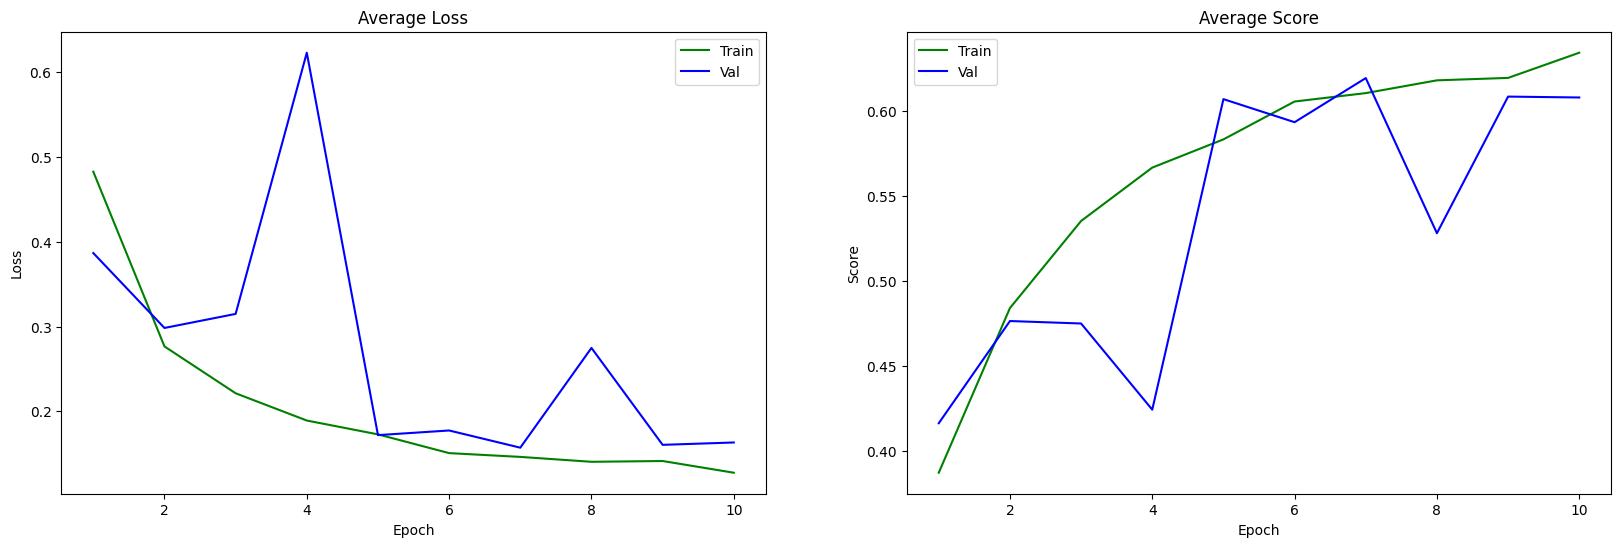

In [ ]:
# AdamW
last_train_score = results[2]['average_train_score'][-1]
last_val_score = results[2]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[2], plotsize=(20, 6))

In [ ]:
# === selecting best LR scheduler ===

models = [
    fast_scnn.FastSCNN(n_classes),
    fast_scnn.FastSCNN(n_classes),
    fast_scnn.FastSCNN(n_classes),
]

results = []
loss_fn = nn.CrossEntropyLoss()

optimizers = [
    torch.optim.Adam(models[0].parameters(), lr=learning_rate),
    torch.optim.Adam(models[1].parameters(), lr=learning_rate),
    torch.optim.Adam(models[2].parameters(), lr=learning_rate)]

scheduler_candidates = [
    None,
    torch.optim.lr_scheduler.LinearLR(optimizers[1], start_factor=0.05),
    torch.optim.lr_scheduler.ExponentialLR(optimizers[2], gamma=0.05)]

for i, scheduler in enumerate(scheduler_candidates):
    model = models[i]
    optimizer = optimizers[i]

    partial_results = training_and_testing.train_model(
        device, model, train_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
        lr_scheduler=scheduler, verbose=True, evaluate=True)
    results.append(partial_results)

Device: cuda.
--- Epoch 1/10 ---
average_train_loss: 0.48354651173974716, average_train_score: 0.38584181666374207
average_val_loss: 0.38545944671782234, average_val_score: 0.4107961654663086
--- Epoch 2/10 ---
average_train_loss: 0.28100613795454343, average_train_score: 0.48383641242980957
average_val_loss: 0.24320744758560545, average_val_score: 0.5206595659255981
--- Epoch 3/10 ---
average_train_loss: 0.21843924889197716, average_train_score: 0.5368973016738892
average_val_loss: 0.21563557902025798, average_val_score: 0.5578479766845703
--- Epoch 4/10 ---
average_train_loss: 0.18441991781831807, average_train_score: 0.5684227347373962
average_val_loss: 0.20386561715886706, average_val_score: 0.551628828048706
--- Epoch 5/10 ---
average_train_loss: 0.168188226125349, average_train_score: 0.5872724652290344
average_val_loss: 0.2545387889184649, average_val_score: 0.5306357741355896
--- Epoch 6/10 ---
average_train_loss: 0.15723839209035592, average_train_score: 0.5998833775520325
ave

training score after 10 epochs: 0.636573076248169
validation score after 10 epochs: 0.6346775889396667


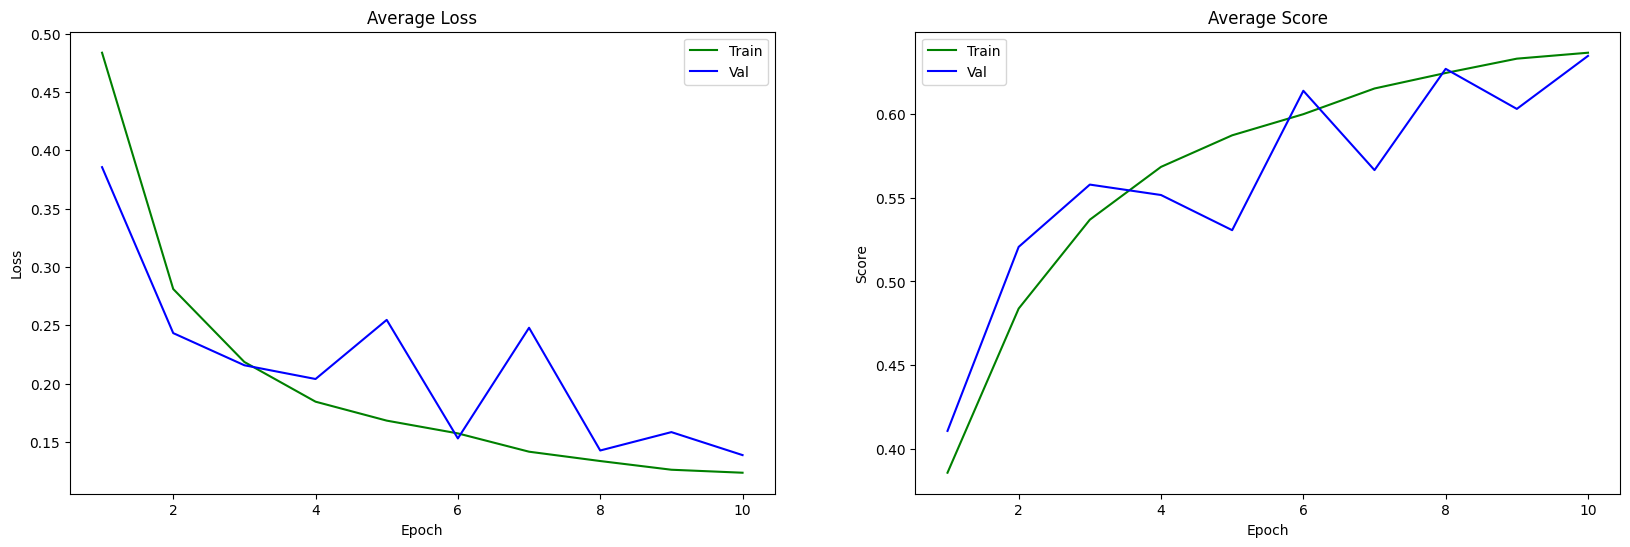

In [ ]:
# no scheduler
last_train_score = results[0]['average_train_score'][-1]
last_val_score = results[0]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[0], plotsize=(20, 6))

training score after 10 epochs: 0.6442115306854248
validation score after 10 epochs: 0.650351345539093


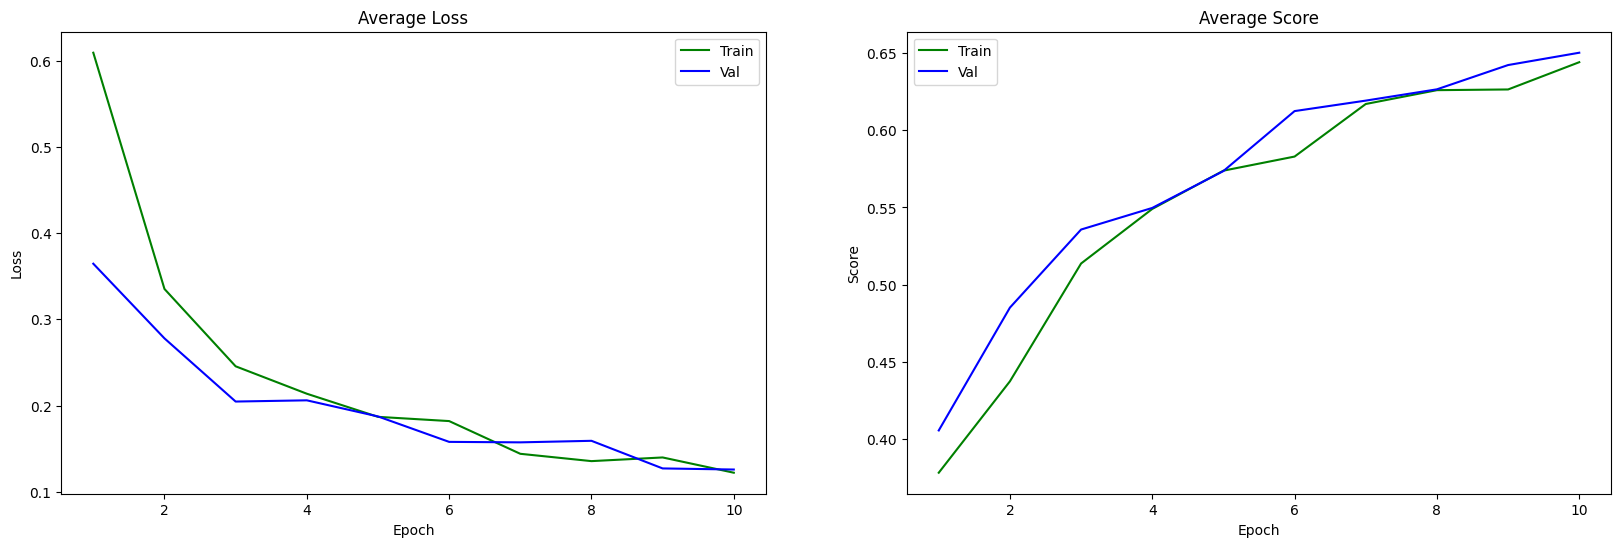

In [ ]:
# linear scheduler
last_train_score = results[1]['average_train_score'][-1]
last_val_score = results[1]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[1], plotsize=(20, 6))

training score after 10 epochs: 0.4946572482585907
validation score after 10 epochs: 0.5076625347137451


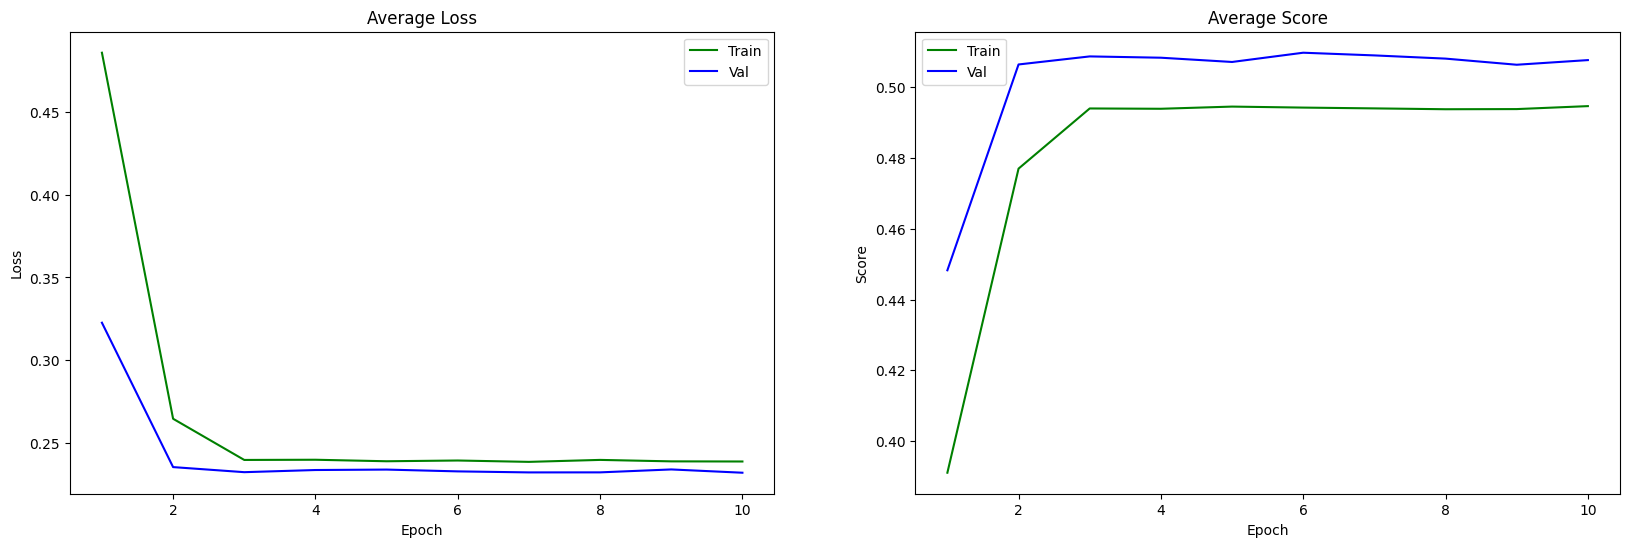

In [ ]:
# exponential scheduler
last_train_score = results[2]['average_train_score'][-1]
last_val_score = results[2]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[2], plotsize=(20, 6))